# Benjamin!
Sorry pour le nom du notebook
et pour les hardcoded paths

Voici grosso modo ce que j'ai fait:
- Discard les valeurs incohérentes
- Convertir en température
- Faire en sorte que à t = 0, notre référence soit normalisé à 22 degrés en soustrayant la référence (moyenne) par (ref[0] - 22) (le 22 degrés est expliqué plus bas)
- Par interpolation, trouver les coeffcients optimaux pour le test centré à partir de celui du 17 Avril.
- Trouver la puissance en utilisant la fonction de degrée 3. (Lorsqu'on aura les bons coefficients, il faudra spécifier les coefficients en fonction de la position)
- Faire un rolling average sur une le kernel_size (7) pour lisser les données (convolve = rolling average)
- Passer le tout dans l'algo prédictif qui correspond à x' = x + c * [x - x[-5]]

Ce qu'il reste à faire:
- Aller effectuer une séquence complète à 5mm (pas juste un échelon)


In [149]:
from utils import *
current_dir = os.curdir
dataPath = "/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/Échelon2.5_20-04.txt"

data = load_data(dataPath)

data_centre_path = "/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/echelon_centre_2023-04-19.txt"
data_centre = load_data(data_centre_path)

data_left5w = "/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/echelon_gauche_5W_1min_-5mm_2023-04-19.txt"
data_left5w = load_data(data_left5w)

data_up5w = "/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/echelon_haut_5W_1min.txt"
data_up5w = load_data(data_up5w)

data_echelon2_5 ="/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/Échelon2.5_20-04.txt"
data_echelon2_5 = load_data(data_echelon2_5)

In [150]:
#discard index [4, 11, 12, 13, 25, 26, 27, 44, 45, 46, 47, 'ref1', 'ref2' , 'ref3']

data.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)
data_centre.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)
data_left5w.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)
data_up5w.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)
data_echelon2_5.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)

In [151]:

data_temp = convert_to_temp(data)
data_centre_temp = convert_to_temp(data_centre)
data_left5w_temp = convert_to_temp(data_left5w)
data_up5w_temp = convert_to_temp(data_up5w)
data_echelon2_5_temp = convert_to_temp(data_echelon2_5)

highest_temp = rank_temperature(data_temp)
highest_temp_centre = rank_temperature(data_centre_temp)
highest_temp_left5w = rank_temperature(data_left5w_temp)
highest_temp_up5w = rank_temperature(data_up5w_temp)
highest_temp_echelon2_5 = rank_temperature(data_echelon2_5_temp)


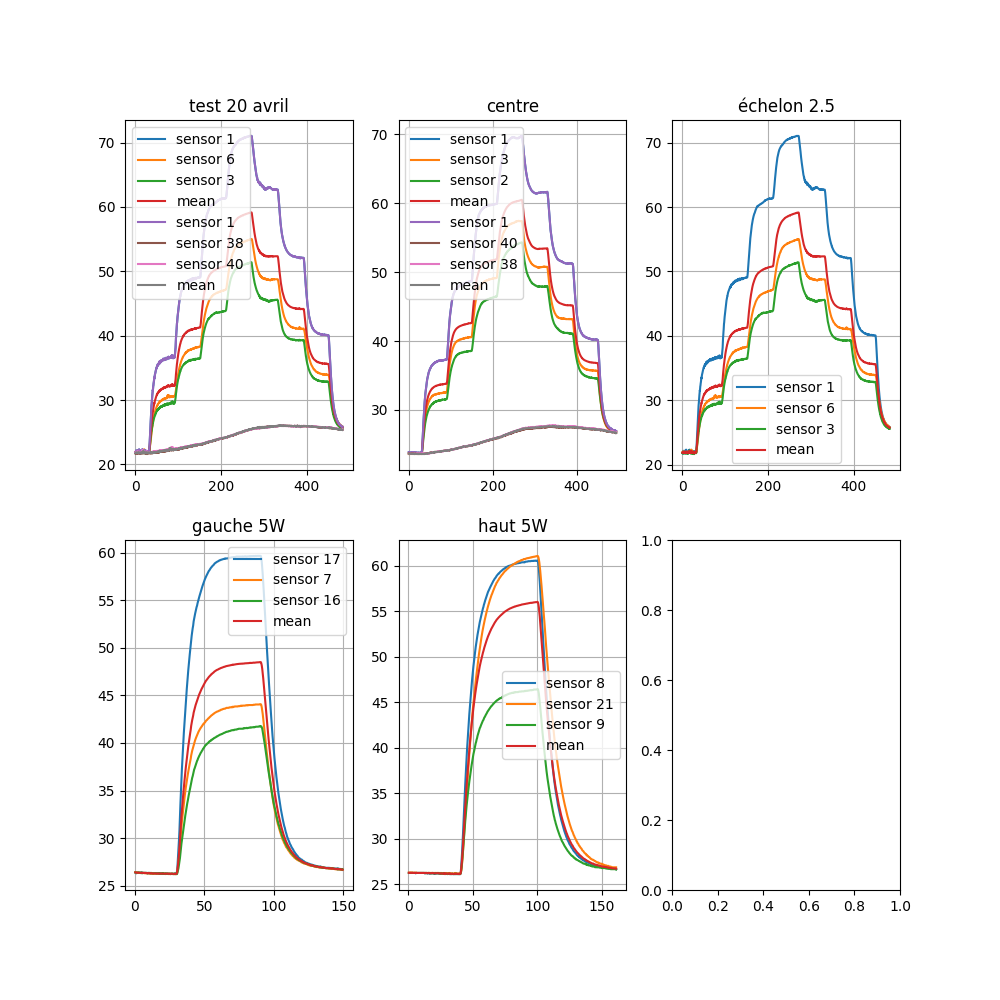

In [152]:
def plot(ax, data, temperature_rank, n, title="", mean=False):
    """
    ax: axis to plot on
    data: data to plot
    temperature_rank: rank of the temperature to plot
    n: number of data to plot
    """
    for i in range(np.abs(n)):
        if n > 0:
            index = temperature_rank[i]
        else:
            index = temperature_rank[-i]
        ax.plot(data["time"], data[index], label="sensor " + str(index))
    if mean:
        if n > 0:
            ax.plot(data["time"], data[temperature_rank[:n]].mean(axis=1), label="mean")
        else:
            ax.plot(data["time"], data[temperature_rank[n:]].mean(axis=1), label="mean")
    ax.legend()
    ax.set_title(title)
    ax.grid(True)
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
n=3
plot(ax[0, 0], data_temp, highest_temp, n, "test 20 avril", mean = True)
plot(ax[0, 0], data_temp, highest_temp, -n, "test 20 avril", mean = True)
plot(ax[0, 1], data_centre_temp, highest_temp_centre, n, "centre", mean=True)
plot(ax[0, 1], data_centre_temp, highest_temp_centre, -n, "centre", mean=True)
plot(ax[1, 0], data_left5w_temp, highest_temp_left5w, n, "gauche 5W", mean=True)
plot(ax[1, 1], data_up5w_temp, highest_temp_up5w, n, "haut 5W", mean=True)
plot(ax[0, 2], data_echelon2_5_temp, highest_temp_echelon2_5, n, "échelon 2.5", mean=True)

La valeur mean n'est clairement pas utilisable encore dans cette étape, on va voir après avoir soustrait la référence.



Il va falloir normaliser en fonction de la température de la pièce. Si on check la température de la pièce des deux premiers graphiques, elle diffère de 2 degrés et cette différence-là est constante dans le temps. On peut donc se donner un facteur de normalisation qui va correspondre à: current_temp = current_temp - (initial_temp - 22). Je ne sais pas si c'est clair, mais c'est ce que j'ai fait dans le code. EN GROS, ça permet de normaliser la température de la référence en fonction de la température de la pièces pour que la fonction de gain marche même si la pièce change de température. Ça peut paraître inutile sauf qu'aujourd'hui, il faisait 2 degrés plus froid et ça nous fait manquer nos valeurs!

Je choisis 22 comme température puisque j'utilise la première acquisition (17 Avril) pour construire mon polynôme.


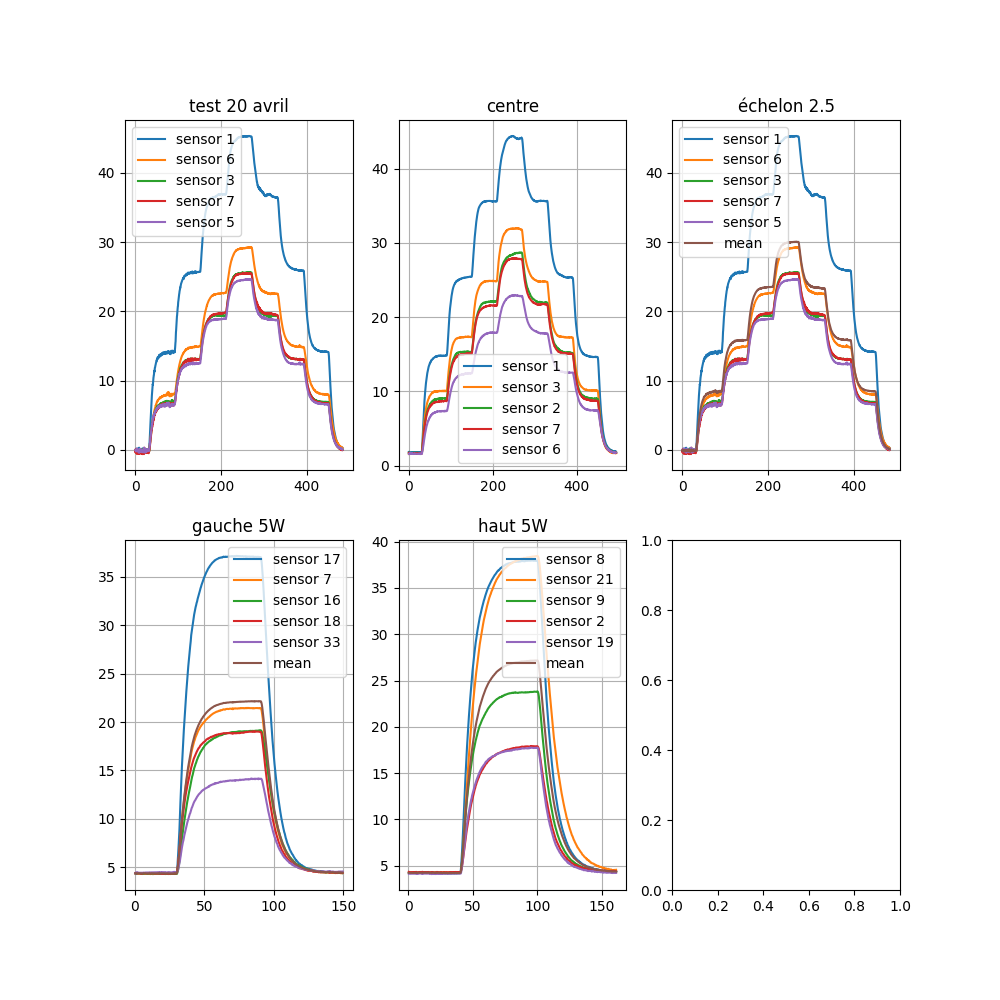

In [153]:
def substract_references(data, temperature_rank, n, norm = 22):
    """
    substract to all data the mean of the n coldest sensors
    """
    data = data.copy()
    #print(data[temperature_rank[-n:]].mean(axis=1))
    data[temperature_rank[-n:]] -= data[temperature_rank[-n:]].iloc[0] - norm
    data[temperature_rank] = data[temperature_rank].sub(data[temperature_rank[-n:]].mean(axis=1), axis=0)
    return data
delta_t = substract_references(data_temp, highest_temp, 6)
delta_t_centre = substract_references(data_centre_temp, highest_temp_centre, 6)
delta_t_left5w = substract_references(data_left5w_temp, highest_temp_left5w, 6)
delta_t_up5w = substract_references(data_up5w_temp, highest_temp_up5w, 6)
delta_t_echelon2_5 = substract_references(data_echelon2_5_temp, highest_temp_echelon2_5, 6)


fig, ax = plt.subplots(2, 3, figsize=(10, 10))
n=5
plot(ax[0, 0], delta_t, highest_temp, n, "test 20 avril")
plot(ax[0, 1], delta_t_centre, highest_temp_centre, n, "centre")
plot(ax[1, 0], delta_t_left5w, highest_temp_left5w, n, "gauche 5W", mean=True)
plot(ax[1, 1], delta_t_up5w, highest_temp_up5w, n, "haut 5W", mean=True)
plot(ax[0, 2], delta_t_echelon2_5, highest_temp_echelon2_5, n, "échelon 2.5", mean=True)




Les delta_t sont exactement les mêmes pour les valeur centrées que pour celles décalées de 2.5mm. On utilisera donc le même gain pour les deux. La thermistance centrale ainsi que le premier ring auront le même gain. On changera pour le deuxième ring et le troisième ring.

[ 4.53263541e-05 -1.46281332e-03  1.95694809e-01 -1.28239044e-02]
[0.00158101 0.1471603  0.04449199]


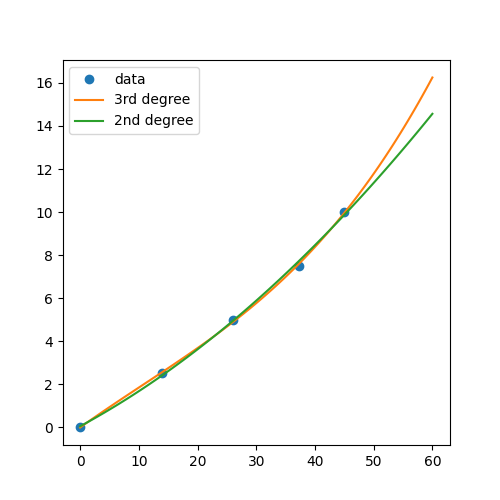

In [154]:
x = [0, 14, 26, 37.3, 45]
y = [0, 2.5, 5, 7.5, 10]
popt, pcov = curve_fit(degree3, x, y)
popt2, pcov2 = curve_fit(degree2, x, y)
print(popt)
print(popt2)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 14, 26, 37.3, 45], [0, 2.5, 5, 7.5, 10], 'o', label = "data")
x = np.linspace(0, 60, 100)
ax.plot(x, degree3(x, *popt), label = "3rd degree")
ax.plot(x, degree2(x, *popt2), label = "2nd degree")
ax.legend()

In [155]:
power = degree3(delta_t, *popt)
power_centre = degree3(delta_t_centre, *popt)
power_left5w = degree3(delta_t_left5w, *popt)
power_up5w = degree3(delta_t_up5w, *popt)
power_echelon2_5 = degree3(delta_t_echelon2_5, *popt)
c, d= 5. , 0
power_predicted = predictive_algo(power[highest_temp[0]], c,d, delta=[5,5,5], separation=False)
power_centre_predicted = predictive_algo(power_centre[highest_temp_centre[0]], c,d, delta=[5,5,5], separation=False)
power_left5w_predicted = predictive_algo(power_left5w[highest_temp_left5w[0]], c,d, delta=[5,5,5], separation=False)
power_up5w_predicted = predictive_algo(power_up5w[highest_temp_up5w[0]], c,d, delta=[5,5,5], separation=False)
power_echelon2_5_predicted = predictive_algo(power_echelon2_5[highest_temp_echelon2_5[0]], c,d, delta=[5,5,5], separation=False)

kernel_size = 7
kernel = np.ones(kernel_size)/kernel_size
power_convolved = np.convolve(power[highest_temp[0]], kernel, mode='same')
power_centre_convolved = np.convolve(power_centre[highest_temp_centre[0]], kernel, mode='same')
power_left5w_convolved = np.convolve(power_left5w[highest_temp_left5w[0]], kernel, mode='same')
power_up5w_convolved = np.convolve(power_up5w[highest_temp_up5w[0]], kernel, mode='same')
power_echelon2_5_convolved = np.convolve(power_echelon2_5[highest_temp_echelon2_5[0]], kernel, mode='same')


power_filtered_predicted = predictive_algo(power_convolved, c,d, delta=[5,5,5], separation=False)
power_centre_filtered_predicted = predictive_algo(power_centre_convolved, c,d, delta=[5,5,5], separation=False)
power_left5w_filtered_predicted = predictive_algo(power_left5w_convolved, c,d, delta=[5,5,5], separation=False)
power_up5w_filtered_predicted = predictive_algo(power_up5w_convolved, c,d, delta=[5,5,5], separation=False)
power_echelon2_5_filtered_predicted = predictive_algo(power_echelon2_5_convolved, c,d, delta=[5,5,5], separation=False)


In [156]:
%matplotlib widget

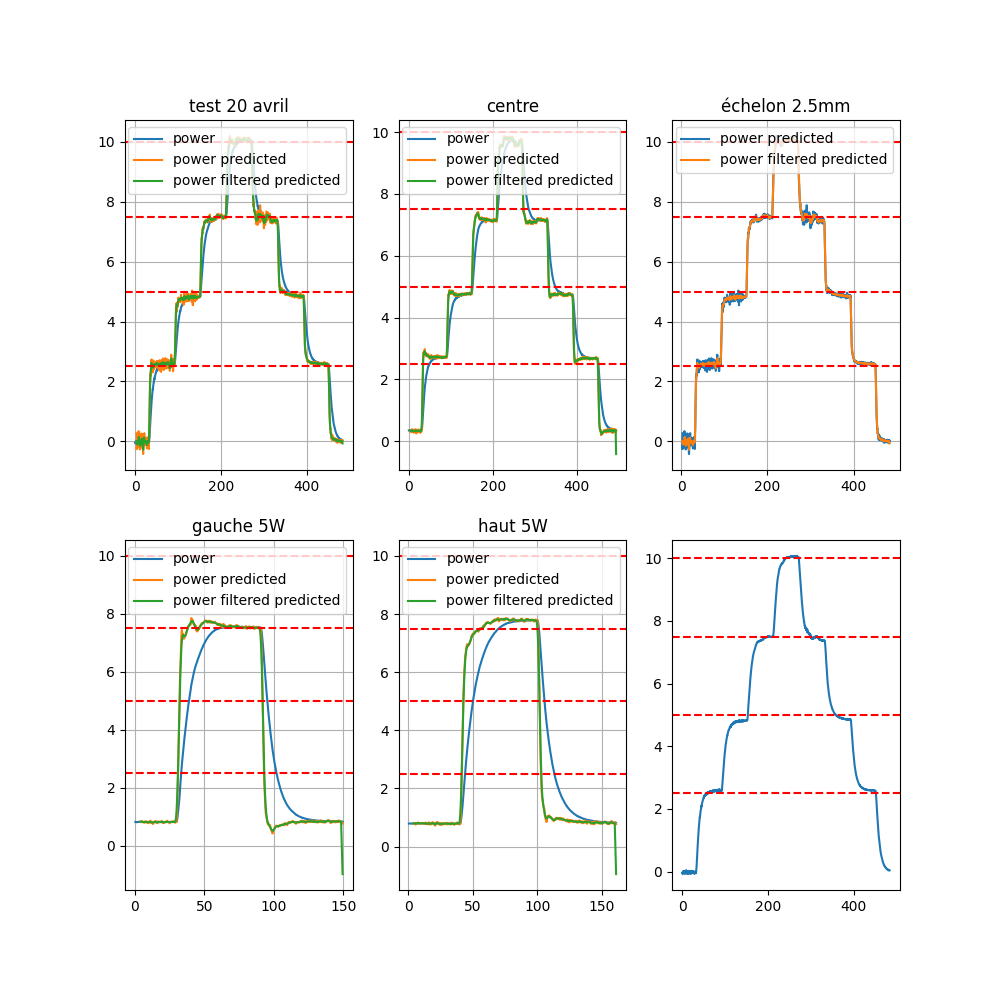

In [157]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0, 0].plot(data_temp["time"], power[highest_temp[0]], label="power")
ax[0, 0].plot(data_temp["time"][10:], power_predicted, label="power predicted")
ax[0, 0].plot(data_temp["time"][10:], power_filtered_predicted, label="power filtered predicted")
ax[0, 0].legend()
ax[0, 0].set_title("test 20 avril")
ax[0, 0].grid()
ax[0, 1].plot(data_centre_temp["time"], power_centre[highest_temp_centre[0]], label="power")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted, label="power predicted")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_filtered_predicted, label="power filtered predicted")
ax[0, 1].legend()
ax[0, 1].set_title("centre")
ax[0, 1].grid()
ax[1, 0].plot(data_left5w_temp["time"], power_left5w[highest_temp_left5w[0]], label="power")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted, label="power predicted")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_filtered_predicted, label="power filtered predicted")
ax[1, 0].legend()
ax[1, 0].set_title("gauche 5W")
ax[1, 0].grid()
ax[1, 1].plot(data_up5w_temp["time"], power_up5w[highest_temp_up5w[0]], label="power")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted, label="power predicted")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_filtered_predicted, label="power filtered predicted")
ax[1, 1].legend()
ax[1, 1].set_title("haut 5W")
ax[1, 1].grid()
ax[1, 2].plot(data_echelon2_5_temp["time"], power_echelon2_5[highest_temp_echelon2_5[0]], label="power")
ax[0, 2].plot(data_echelon2_5_temp["time"][10:], power_echelon2_5_predicted, label="power predicted")
ax[0, 2].plot(data_echelon2_5_temp["time"][10:], power_echelon2_5_filtered_predicted, label="power filtered predicted")
ax[0, 2].legend()
ax[0, 2].set_title("échelon 2.5mm")
ax[0, 2].grid()
#plot dot hline at 2.5, 5, 7.5 and 10W for each plot
for i in range(2):
    for j in range(3):
        ax[i, j].axhline(y=2.5, color='r', linestyle='--')
        ax[i, j].axhline(y=5, color='r', linestyle='--')
        ax[i, j].axhline(y=7.5, color='r', linestyle='--')
        ax[i, j].axhline(y=10, color='r', linestyle='--')



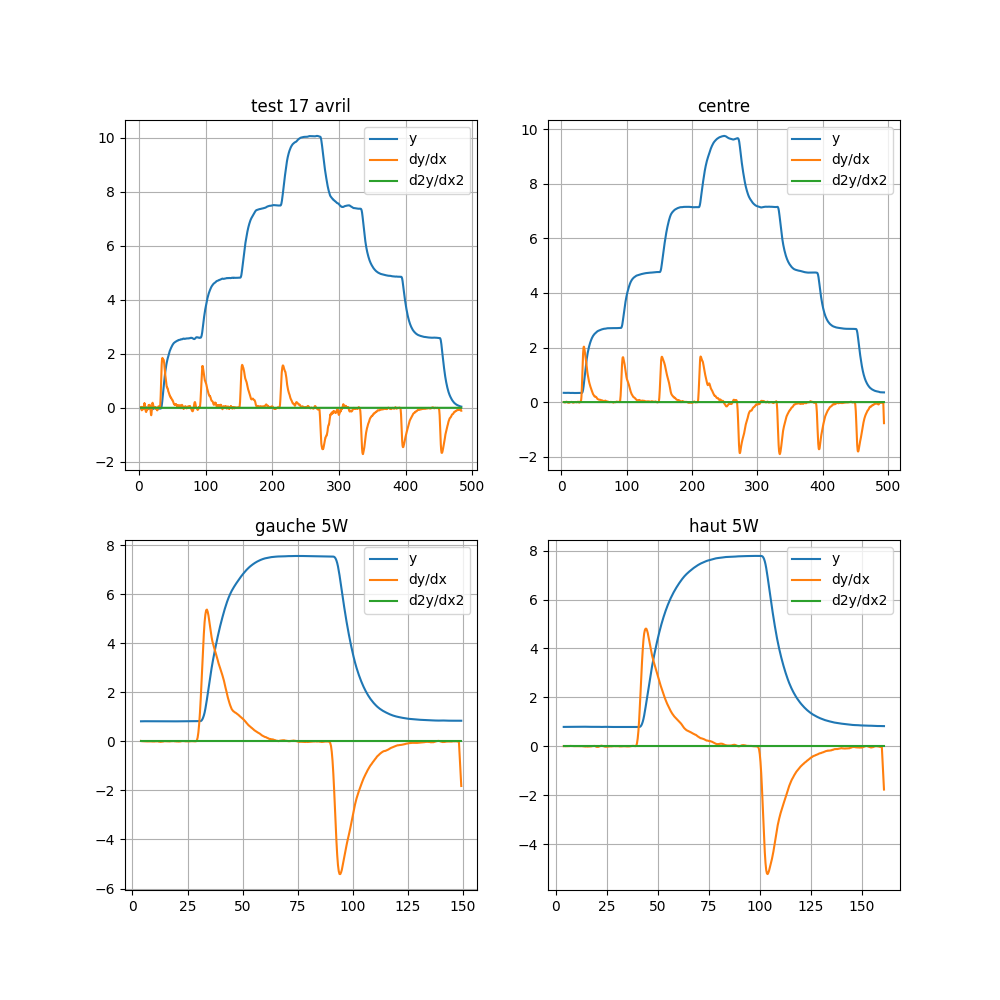

In [158]:
power_predicted_sepate = predictive_algo(power_convolved, c,d, delta=[5,5,5], separation=True)
power_centre_predicted_sepate = predictive_algo(power_centre_convolved, c,d, delta=[5,5,5], separation=True)
power_left5w_predicted_sepate = predictive_algo(power_left5w_convolved, c,d, delta=[5,5,5], separation=True)
power_up5w_predicted_sepate = predictive_algo(power_up5w_convolved, c,d, delta=[5,5,5], separation=True)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(data_temp["time"][10:], power_predicted_sepate[0], label="y")
ax[0, 0].plot(data_temp["time"][10:], power_predicted_sepate[1], label="dy/dx")
ax[0, 0].plot(data_temp["time"][10:], power_predicted_sepate[2], label="d2y/dx2")
ax[0, 0].legend()
ax[0, 0].set_title("test 17 avril")
ax[0, 0].grid()
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted_sepate[0], label="y")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted_sepate[1], label="dy/dx")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted_sepate[2], label="d2y/dx2")
ax[0, 1].legend()
ax[0, 1].set_title("centre")
ax[0, 1].grid()
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted_sepate[0], label="y")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted_sepate[1], label="dy/dx")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted_sepate[2], label="d2y/dx2")
ax[1, 0].legend()
ax[1, 0].set_title("gauche 5W")
ax[1, 0].grid()
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted_sepate[0], label="y")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted_sepate[1], label="dy/dx")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted_sepate[2], label="d2y/dx2")
ax[1, 1].legend()
ax[1, 1].set_title("haut 5W")
ax[1, 1].grid()

Bonne nouvelle, les deux du haut semble bien marcher. Ceux décalés en x et en y ont une valeur plus élevée ce qui est attendu. Un paramètre 5/7 devra être ajouté. Jeudi, on refait un test en échelon à 10W à 5mm de chaque bord, en haut et en bas, puis à 2.5mm. En gros, chaque anneau devra avoir sa propre courbe de degrée 3. 

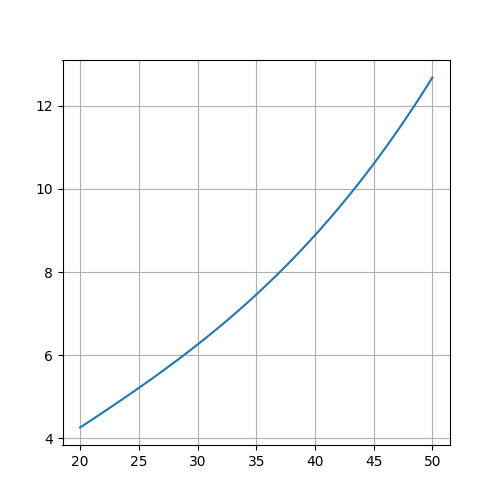

In [159]:
x = np.linspace(20, 50, 100)
y= degree3(x, 8.87865829e-05, -4.81946187e-03,  2.72133515e-01,  2.93516319e-02)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y)
ax.grid()